### Notes
This code was taken from /icecontinuum/jadams/pythoncode/continuum_model6.ipynb, keeping only the 0d dynamics.

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff6 as ds
from copy import copy as dup
from scipy.integrate import odeint

In [9]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [10]:
#Setting up the system
# Number of iterations to calculate Nliq from Ntot
niter = 1

# Message
print("Starting a new system")
nx = 500 # Number of points in simulation box
xmax = 50
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltaX = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)

# Initialize as a pre-equilibrated layer of liquid over ice
Nice = np.ones(boxpoints)
Fliq = ds.getNliq_array(Nice,Nstar,Nbar,niter) # Fliq is the liquid fraction

Starting a new system


<IPython.core.display.Javascript object>


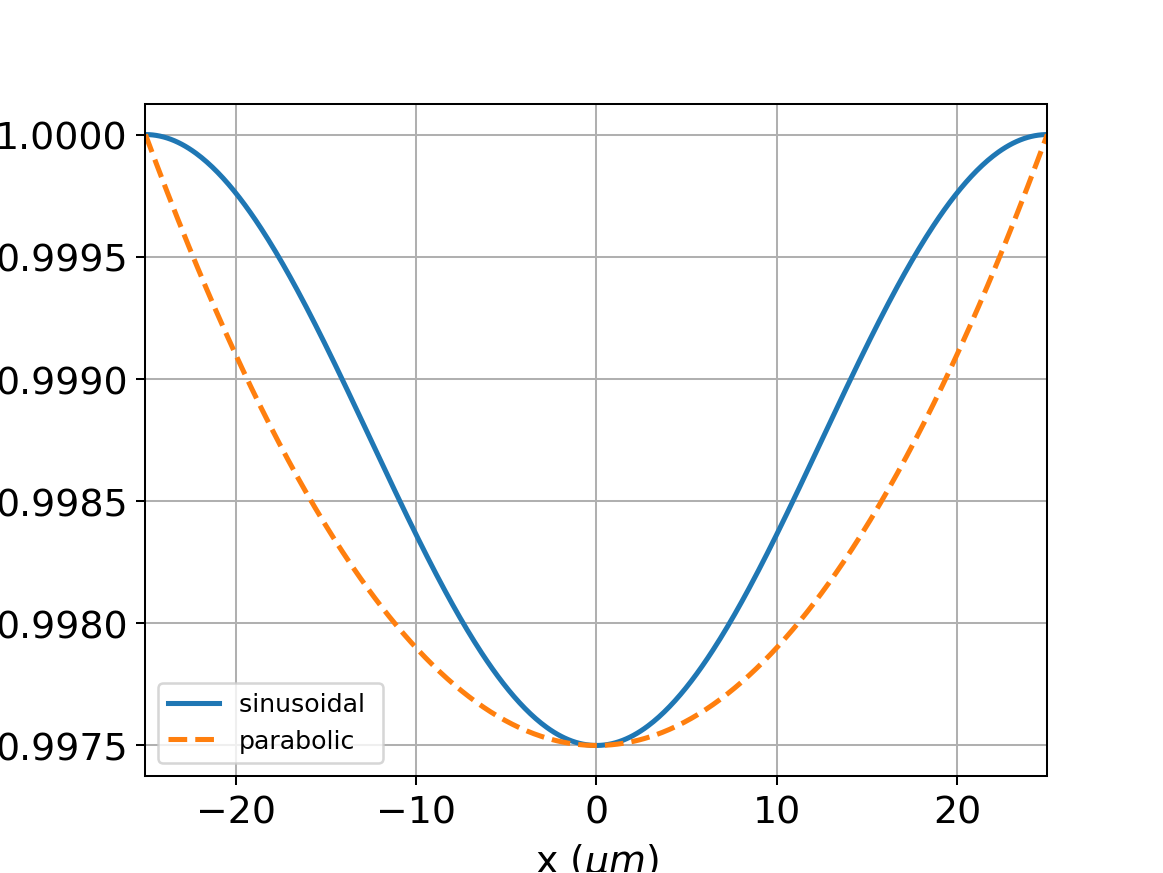

In [11]:
# Lay out the system
Ntot = Fliq + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]
#Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const #NOTE: this is unused

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 10
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep_sinusoid = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid') #NOTE i think this should be nx not xmax
sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic')
sigmastepstyle = 'sinusoid'
if sigmastepstyle=='sinusoid':
    sigmastep = sigmastep_sinusoid
elif sigmastepstyle=='parabolic':
    sigmastep = sigmastep_parabolic
else:
    print('bad choice')

# Graph sigma(x)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid,sigmastep_sinusoid/sigmastepmax, \
         x-xmid, sigmastep_parabolic/sigmastepmax, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

In [12]:
# These are run control parameters

# Flag for explicit updating Fliq(Ntot) every step
updatingFliq = True

# Set up a maximum number of iterations or layers
uselayers = True

# 0D run
if uselayers:
    layermax_0D = 10
else:
    countermax_0D = 100

In [13]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltaT_max (Diffusion time)', dtmax)
print('deltaT =', deltaT)
print('deprate =', deprate, 'monolayers/us')
print('nmid', nmid)
print('N*', Nstar)
print('N*x2pi', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltaX', deltaX)
print('sigma_0 =', sigma0)
print('sigmastepmax =', sigmastepmax)
print('center reduction', center_reduction, '%')
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deltaT_max (Diffusion time) 50.20060160400962
deltaT = 1.0040120320801924
deprate = 0.16333333333333333 monolayers/us
nmid 250
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.10020040080160321
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 0.25 %
max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
nu_kin = 49 um/sec


<IPython.core.display.Javascript object>


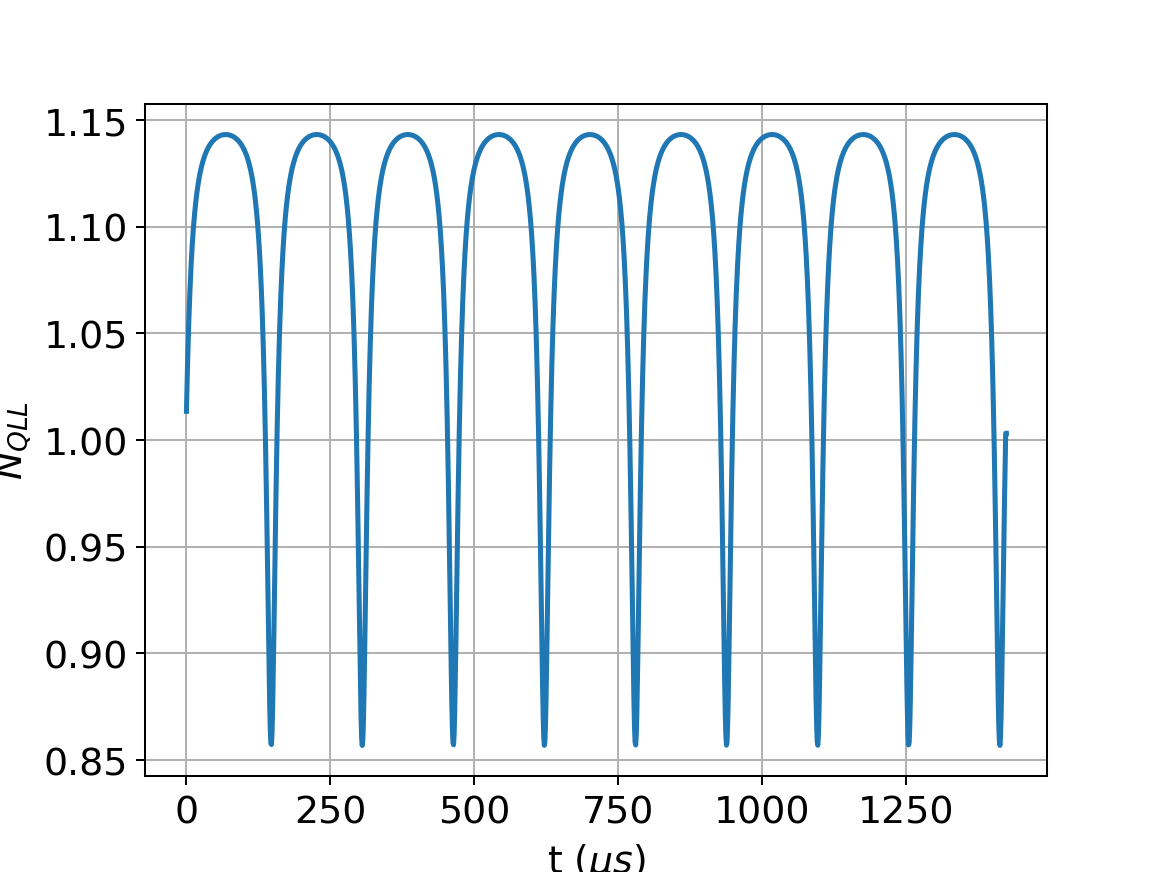

0-D Modeled growth rate, um/s 1.8972249178985485
0-D Modeled growth rate, ml/us 0.006324083059661829
0-D Modeled alpha 0.1935943793774029


In [14]:
# This is the 0-d run
# Bundle parameters for ODE solver
params = np.array([Nbar, Nstar, sigmastepmax, sigma0, deprate])

y0 = [Nbar,0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,niter))
    ylast = list(y[1,:])
    tlast += deltaT
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to Fliq
    Fliqlast, Ntotlast = ylast

    if updatingFliq:
        Fliqlast = ds.getNliq(Ntotlast,Nstar,Nbar,niter) # This updates Fliqlast and ylast!
        ykeep_0D[counter][0] = Fliqlast # Saves the updated Fliq for this step
    Nicelast = Ntotlast - Fliqlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    if uselayers:
        if layer > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

# Plot results
fignum +=1
plt.figure(fignum)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print( "0-D Modeled alpha", alpha_0d)